In [2]:
import pickle
import pandas as pd
import json 
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import cv2

SHOULD_REBUILD = False
PREPROCESSED_FORM_IMG_PATH = 'preprocessed_form_imgs/'
FORM_IMG_SIZE = (3542, 2479)
DET_CKPT = "straight_model/weights"


# Loading dataset

In [3]:
def get_preprocessed_form_img_path_from_id(form_id):
    return PREPROCESSED_FORM_IMG_PATH + form_id + '.png'

df = pd.read_pickle('../../pickle/df.pickle')
df['form_img_path'] = '../' + df['form_img_path_y']
df = df.drop(columns=['form_img_path_y'])

bad_df = df[df['total_words'] != df['correct_words']]
df = df[df['total_words'] == df['correct_words']]
df.head()

,index,word_id,gray_level,x,y,w,h,tag,transcription,word_img_path,...,form_id,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path
36,52,a01-000x-00-00,182,375,767,35,67,AT,A,../data/words/a01/a01-000x/a01-000x-00-00.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
37,53,a01-000x-00-01,182,506,763,143,66,NN,MOVE,../data/words/a01/a01-000x/a01-000x-00-01.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
38,54,a01-000x-00-02,182,730,760,44,70,TO,to,../data/words/a01/a01-000x/a01-000x-00-02.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
39,55,a01-000x-00-03,182,832,764,89,114,VB,stop,../data/words/a01/a01-000x/a01-000x-00-03.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
40,56,a01-000x-00-04,182,1001,760,84,71,NPT,Mr.,../data/words/a01/a01-000x/a01-000x-00-04.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png


In [4]:
import numpy as np

print("Dataset length: {}".format(len(df)))
print("Max x: {}".format(np.max(df.x.values)))
print("Max y: {}".format(np.max(df.y.values)))

Dataset length: 41981
Max x: 2458
Max y: 2773


# Visualizing

We will here render a few form images to better compare them with the preprocessed ones.

In [5]:
@tf.function
def load_image(filepath, resize=None):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)
    if resize:
        return tf.image.resize(im, resize)
    return im

2023-02-28 08:39:31.838028: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


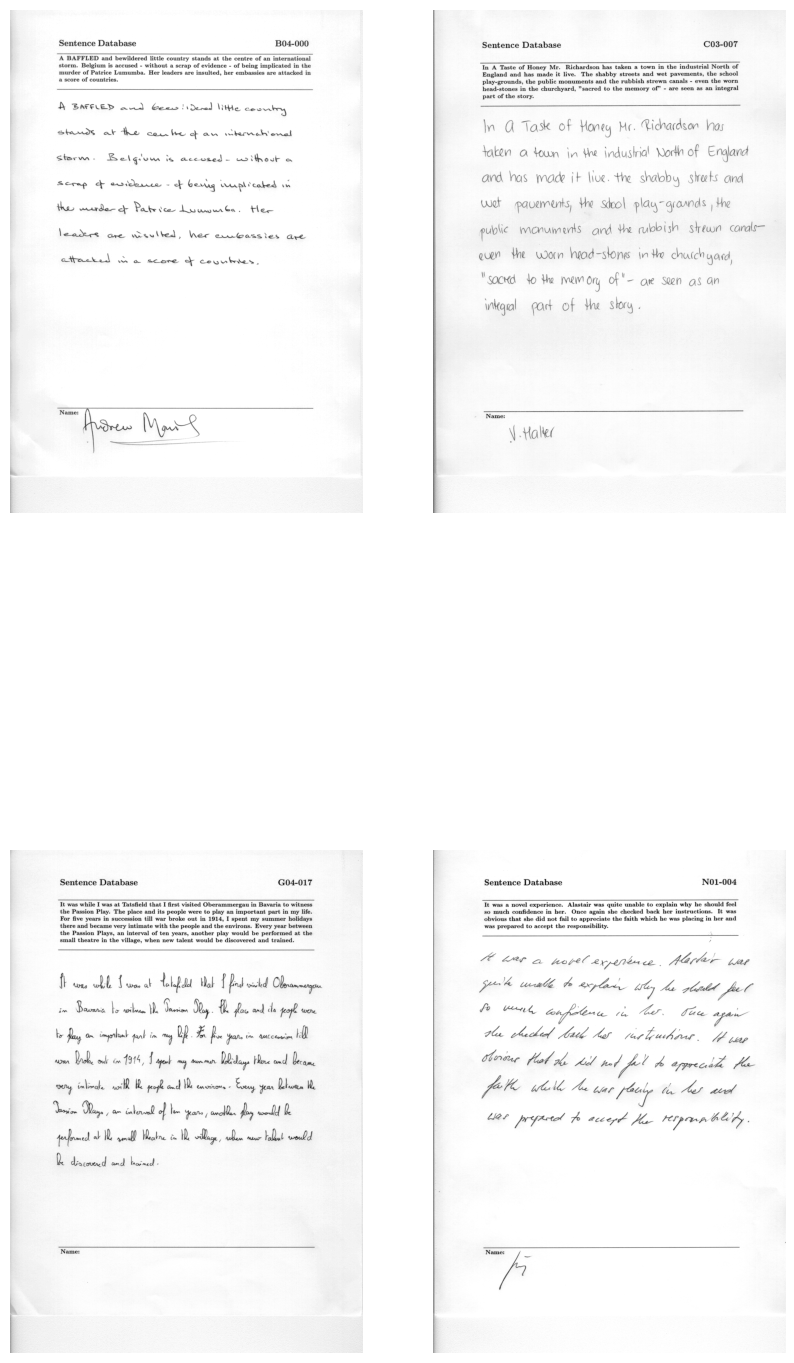

In [6]:
fig = plt.figure(figsize=(10,20))
nb_rows = 2
nb_cols = 2
img_paths = random.sample(list(df.form_img_path), nb_rows * nb_cols)
for i in range(nb_rows * nb_cols):
    fig.add_subplot(nb_rows, nb_cols, i + 1)
    plt.imshow(load_image(img_paths[i]), cmap='gray')
    plt.axis('off')
plt.show()

# Preprocessing

In [7]:
import tensorflow_addons as tfa
import math 

@tf.function
def rotate_fixed_size_image(img, rotation_deg):
    img_original_size = tf.shape(img)
    # Add padding to later rotate without losing info
    padding_scale = abs(rotation_deg / 100)  
    dx = int(padding_scale * float(img_original_size[1]))
    dy = int(padding_scale * float(img_original_size[0]))
    # top, bottom, left, right
    img = tf.pad(img[..., 0], [[dx, dx], [dy, dy]], constant_values=1)

    # Rotate 
    img = tfa.image.rotate(img, rotation_deg * math.pi / 180, fill_value=1.0)

    # Resize
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.resize(img, (int(img_original_size[0]), int(img_original_size[1])))
    return img

@tf.function
def preprocess(filepath, img_size=(32, 128), data_augmentation=False, is_threshold=True, scale=1, with_rotation=False):
    img = load_image(filepath)/255 # To work with values between 0 and 1
    img_original_size = tf.shape(img)

    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = tf.ones([img_size[0], img_size[1], 1])
        res = tf.expand_dims(img, -1)
        return res
    
    if with_rotation:
        rotation_deg = int(np.random.normal() * 25)
        img = rotate_fixed_size_image(img, rotation_deg)

    # increase dataset size by applying random stretches to the images
    if data_augmentation:
        stretch = scale*(tf.random.uniform([1], 0, 1)[0] - 0.3) 
        w_stretched = tf.maximum(int(float(img_original_size[0]) * (1 + stretch)), 1) # random width, but at least 1
        img = tf.image.resize(img, (w_stretched, img_original_size[1])) # stretch horizontally by factor 0.5 .. 1.5


    # Rescale
    # create target image and copy sample image into it
    (wt, ht) = img_size
    w, h = float(tf.shape(img)[0]), float(tf.shape(img)[1])
    fx = w / wt
    fy = h / ht
    f = tf.maximum(fx, fy)
    newSize = (tf.maximum(tf.minimum(wt, int(w / f)), 1), tf.maximum(tf.minimum(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = tf.image.resize(img, newSize)

    # Add padding
    dx = wt - newSize[0]
    dy = ht - newSize[1]
    if data_augmentation:
        dx1=0
        dy1=0
        if dx != 0:
            dx1 = tf.random.uniform([1], 0, dx, tf.int32)[0]
        if dy != 0:
            dy1 = tf.random.uniform([1], 0, dy, tf.int32)[0]
        img = tf.pad(img[..., 0], [[dx1, dx-dx1], [dy1, dy-dy1]], constant_values=1)
    else:
        img = tf.pad(img[..., 0], [[0, dx], [0, dy]], constant_values=1)

    if is_threshold:
        img = 1-(1-img)*tf.cast(img < 0.8, tf.float32)

    img = tf.expand_dims(img, -1)
    return img

def generate_preprocessed_form_imgs_from_df(df, img_size = FORM_IMG_SIZE, folder_name = PREPROCESSED_FORM_IMG_PATH, offset=0, limit=1500):
    i = 0
    form_df = df.drop_duplicates(subset=['form_id'])
    for index, row in tqdm(form_df.iterrows(), total=len(form_df)):
        if index < offset :
            continue
        path = row.form_img_path
        img_array = preprocess(path, img_size=img_size).numpy()
        cv2.imwrite(folder_name + '/' + row.form_id + '.png', cv2.cvtColor(img_array * 255, cv2.COLOR_RGB2BGR))
        i += 1
        if limit <= i:
            break

## Test preprocessing

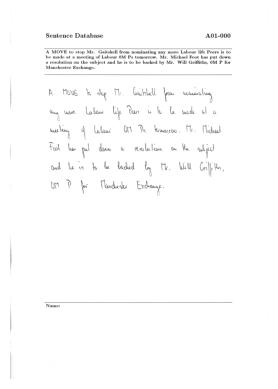

In [8]:
test_form_img_path = df.iloc[5].form_img_path
img_array = preprocess(test_form_img_path, img_size=FORM_IMG_SIZE, with_rotation=False).numpy()
plt.axis('off')
plt.imshow(img_array, cmap='gray');
plt.show()

## Generate preprocessed images

In [19]:
# Decomment this to re-generate form imgs
# generate_preprocessed_form_imgs_from_df(df, img_size=FORM_IMG_SIZE, offset=0, limit=1500)

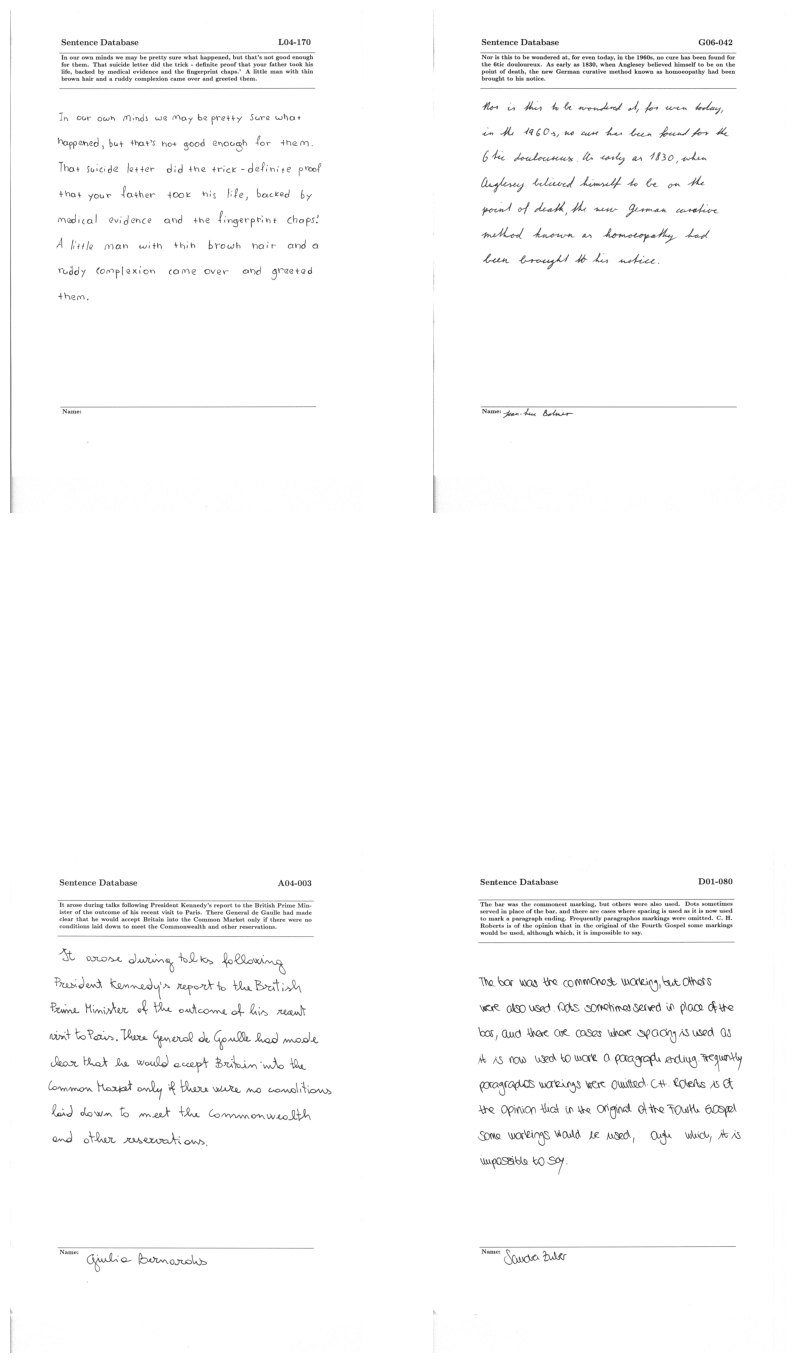

In [9]:
fig = plt.figure(figsize=(10,20))
nb_rows = 2
nb_cols = 2
form_img_ids = random.sample(list(set(df.form_id)), nb_rows * nb_cols)
for i in range(nb_rows * nb_cols):
    fig.add_subplot(nb_rows, nb_cols, i + 1)
    plt.imshow(plt.imread(get_preprocessed_form_img_path_from_id(form_img_ids[i])), cmap='gray')
    plt.axis('off')
plt.show()

# Find full coordinates

In [10]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile


def scale_doctr_coords(img_detection_result, size = (1,1)):
    ''' 
    Return the scaled coordinates as an array of 4-point arrays 
    https://mindee.github.io/doctr/modules/io.html#block
    '''
    height = size[0]
    width = size[1]

    trans_coords = []
    for arr in img_detection_result:
        xmin = arr[0]
        ymin = arr[1]
        xmax = arr[2]
        ymax = arr[3]

        trans_coords.append(
            [
                [xmin * width, ymin * height], #xmin #ymin
                [xmax * width, ymin * height], #xmax #ymin
                [xmax * width, ymax * height], #xmax #ymax
                [xmin * width, ymax * height], #xmin #ymax
        ]
    )
    return trans_coords


def get_doctr_coords_for_img(model, img_path, is_scaling=True):
    form_img_arr = plt.imread(img_path)
    doc = DocumentFile.from_images(img_path)
    det_res = model.det_predictor(doc)
    shape = (1, 1)
    if is_scaling:
        shape = form_img_arr.shape
    return scale_doctr_coords(det_res[0], size=shape)

def create_full_coords_doctr_file(df, save=False):
    if not save:
        with open("doctr_coords.json") as f:
            return json.load(f)

    doctr_coords_json = {}

    model = ocr_predictor(
        det_arch = 'db_resnet50',    
        reco_arch = 'crnn_vgg16_bn', 
        pretrained = True
    )

    for form_id in tqdm(list(set(df.form_id))):
        form_img_path = get_preprocessed_form_img_path_from_id(form_id)
        doctr_coords_json[form_img_path] = get_doctr_coords_for_img(model, form_img_path)
        
    with open("doctr_coords.json", "w") as outfile:
        json.dump(doctr_coords_json, outfile, indent=4, sort_keys=False)
    return doctr_coords_json

/Users/jpec/miniconda3/envs/work/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
doctr_coords_json = create_full_coords_doctr_file(df, save=SHOULD_REBUILD)

### Test with doctr on-the-fly coords

In [12]:
test_form_id = df.iloc[0].form_id
form_img_path = get_preprocessed_form_img_path_from_id(test_form_id)


original_model = ocr_predictor(
    det_arch = 'db_resnet50',    
    reco_arch = 'crnn_vgg16_bn', 
    pretrained = True
)
doc = DocumentFile.from_images(form_img_path)
res = original_model(doc)

def get_on_the_fly_doctr_coords(form_img_path):
    original_model = ocr_predictor(
        det_arch = 'db_resnet50',    
        reco_arch = 'crnn_vgg16_bn', 
        pretrained = True
    )
    doc = DocumentFile.from_images(form_img_path)
    return original_model.det_predictor(doc)[0]

def get_on_the_fly_scaled_doctr_coords(form_img_path, size=FORM_IMG_SIZE):
    return scale_doctr_coords(get_on_the_fly_doctr_coords(form_img_path), size)


abs_coords = get_on_the_fly_scaled_doctr_coords(form_img_path)

In [13]:
def plot_coords_only(abs_coords, color='red'):
    for polygon_data in abs_coords:
        x = []
        y = []
        for point in polygon_data:
            x.append(point[0])
            y.append(point[1])
        x.append(polygon_data[0][0])
        y.append(polygon_data[0][1])
        plt.plot(x, y, color=color)


def plot_coords(form_img_path, abs_coords):
    plt.axis('off')
    plt.imshow(load_image(form_img_path), cmap='gray')
    plot_coords_only(abs_coords)
    plt.show()

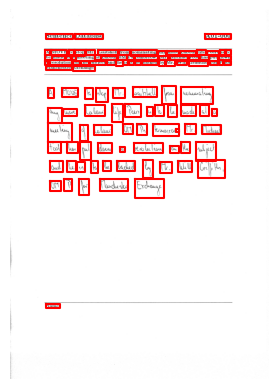

In [14]:
plot_coords(form_img_path, abs_coords)

### Test : expected result

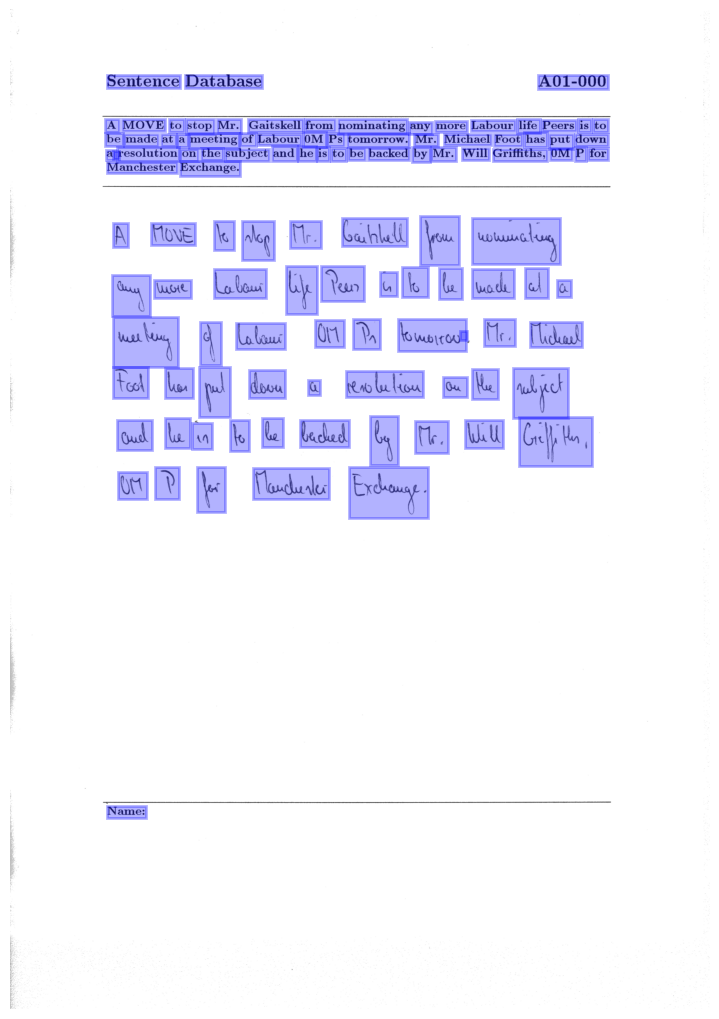

In [15]:
res.show(doc)

### Test with saved doctr coords

[[[341.3466796875, 2822.53125], [481.7587890625, 2822.53125], [481.7587890625, 2864.0390625], [341.3466796875, 2864.0390625]], [[1200.765625, 1622.263671875], [1479.1689453125, 1622.263671875], [1479.1689453125, 1802.130859375], [1200.765625, 1802.130859375]], [[382.501953125, 1639.55859375], [484.1796875, 1639.55859375], [484.1796875, 1736.41015625], [382.501953125, 1736.41015625]], [[861.83984375, 1625.72265625], [1130.5595703125, 1625.72265625], [1130.5595703125, 1736.41015625], [861.83984375, 1736.41015625]], [[663.326171875, 1622.263671875], [760.162109375, 1622.263671875], [760.162109375, 1781.376953125], [663.326171875, 1781.376953125]], [[513.23046875, 1622.263671875], [597.9619140625, 1622.263671875], [597.9619140625, 1736.41015625], [513.23046875, 1736.41015625]], [[1803.5693359375, 1445.85546875], [2062.60546875, 1445.85546875], [2062.60546875, 1618.8046875], [1803.5693359375, 1618.8046875]], [[1433.171875, 1459.69140625], [1549.375, 1459.69140625], [1549.375, 1570.37890625]

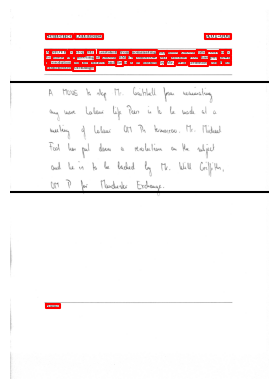

In [47]:
test_form_id = df.iloc[0].form_id
form_img_path = get_preprocessed_form_img_path_from_id(test_form_id)
abs_coords = doctr_coords_json[form_img_path]
# TODO Jpec
form_df = df[df['form_id']==test_form_id]
margin = 50
boundaries = form_df.y.min() - margin, form_df.y.max() + margin
plt.axhline(boundaries[0], color='black')
plt.axhline(boundaries[1], color='black')
new_abs_coords = []
for box_points in abs_coords:
    is_out = True
    for box_point in box_points:
        y = box_point[1]
        if y > boundaries[0] and y < boundaries[1]:
            is_out = False
    if is_out:
        new_abs_coords.append(box_points)

plot_coords(form_img_path, new_abs_coords)
# plot_coords(form_img_path, abs_coords)

### Test with db coords

In [16]:
test_form_id = df.iloc[0].form_id
test_writer_id = df.iloc[0].writer_id
form_img_path = get_preprocessed_form_img_path_from_id(test_form_id)


def get_db_coords_from_df(df, form_id, writer_id):
    df = df[(df['form_id'] == form_id) & (df['writer_id'] == writer_id)]

    coords = []
    for index, row in df.iterrows():
        coords.append([
            [row.x, row.y],
            [row.x + row.w, row.y],
            [row.x + row.w, row.y + row.h],
            [row.x, row.y + row.h],
        ])
    return coords

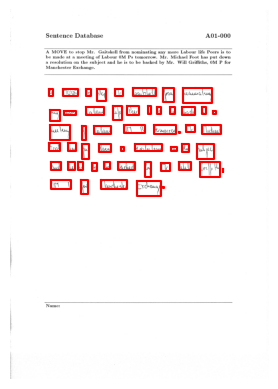

In [17]:
plot_coords(form_img_path, get_db_coords_from_df(df, test_form_id, test_writer_id))

### Plot DB + Doctr


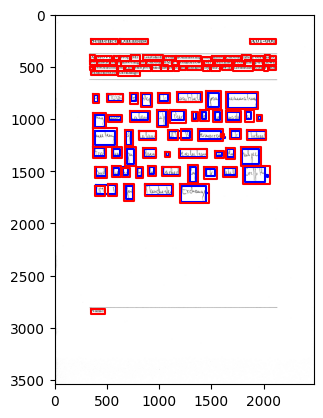

In [18]:
def show_full_plot(index = 0, should_load_preprocessed=True):
    test_form_id = df.iloc[index].form_id
    test_writer_id = df.iloc[index].writer_id

    if should_load_preprocessed:
        form_img_path = get_preprocessed_form_img_path_from_id(test_form_id)
        img = load_image(form_img_path)
    else:
        form_img_path = df.iloc[index].form_img_path
        img = load_image(form_img_path)

    doctr_coords = get_on_the_fly_scaled_doctr_coords(form_img_path, img.shape)
    db_coords = get_db_coords_from_df(df, test_form_id, test_writer_id)
    
    plot_coords_only(db_coords, 'blue')
    plot_coords_only(doctr_coords, 'red')
    plt.imshow(img)
    plt.show()




show_full_plot()

# Train/Test Split

In [19]:
import hashlib

IMG_DIM_ATTR_LABEL = 'img_dimensions'
IMG_HASH_ATTR_LABEL = 'img_hash'
POLYGON_ATTR_LABEL = 'polygons'
IS_TRAIN_ATTR_LABEL = 'is_train'


def get_img_hash(img_arr):
    return hashlib.sha256(img_arr).hexdigest()

def split_in_train_val_img_dicts(df, doctr_coords_json, save=SHOULD_REBUILD):
    if not save:
        with open("text_detection_train/labels.json") as f:
            train_json = json.load(f)
            
        print(len(train_json), "images will be used for training")

        with open("text_detection_val/labels.json") as f:
            val_json = json.load(f)
            
        print(len(val_json), "images will be used for validation")
        return train_json, val_json
    train_img_dict = {}
    val_img_dict = {}
    i = 0
    nb_words = len(df)
    nb_forms = len(list(set(df.form_id)))
    form_ids = set()
    form_img_infos = {}

    for index, row in tqdm(df.iterrows(), total=len(df)):
        i += 1
        x = row.x
        y = row.y
        width = row.w
        height = row.h
        form_id = row.form_id
        form_ids.add(form_id)
        form_img_path = get_preprocessed_form_img_path_from_id(row.form_id)


        if form_img_path in form_img_infos:
            form_img_hash = form_img_infos[form_img_path]['hash']
            img_shape = form_img_infos[form_img_path]['shape']
        else:
            form_img_arr = plt.imread(form_img_path, )
            form_img_hash = get_img_hash(form_img_arr)
            img_shape = form_img_arr.shape

            form_img_infos[form_img_path] = {
                'hash': form_img_hash,
                'shape': img_shape,
            }

        is_train = (len(form_ids) < int(nb_forms * 0.8))           

        box_coordinates = [
            [x, y],
            [x + width, y],
            [x + width, y + height],
            [x, y + height],
        ]

        form_img_filename = row.form_id + '.png'
        form_img_filename = form_img_filename.split('/')[-1]

        doctr_coords = doctr_coords_json[form_img_path]
        # TODO Added
        form_df = df[(df['form_id'] == form_id)]
        margin = 50
        boundaries = form_df.y.min() - margin, form_df.y.max() + margin
    
        new_doctr_coords = []
        for box_points in doctr_coords:
            is_out = True
            for box_point in box_points:
                y = box_point[1]
                if y > boundaries[0] and y < boundaries[1]:
                    is_out = False
            if is_out:
                new_doctr_coords.append(box_points)
        doctr_coords = new_doctr_coords
        # End Added

        if is_train:
            future_img_path = 'text_detection_train/'
            if not form_img_filename in train_img_dict:
                train_img_dict[form_img_filename] = {
                    IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                    IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                    POLYGON_ATTR_LABEL: doctr_coords,
                }
            train_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)
        else: 
            future_img_path = 'text_detection_val/'
            if not form_img_filename in val_img_dict:
                val_img_dict[form_img_filename] = {
                    IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                    IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                    POLYGON_ATTR_LABEL: doctr_coords,
                }
            val_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)
        last_form_id = form_id

    with open("text_detection_train/labels.json", "w") as outfile:
        json.dump(train_img_dict, outfile, indent=4, sort_keys=False)
    with open("text_detection_val/labels.json", "w") as outfile:
        json.dump(val_img_dict, outfile, indent=4, sort_keys=False)

    return train_img_dict, val_img_dict

In [20]:
train_json, val_json = split_in_train_val_img_dicts(df, doctr_coords_json, save=SHOULD_REBUILD)

465 images will be used for training
118 images will be used for validation


# Checking coordinates

a01-000x.png


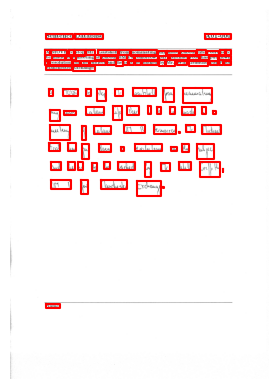

a01-007.png


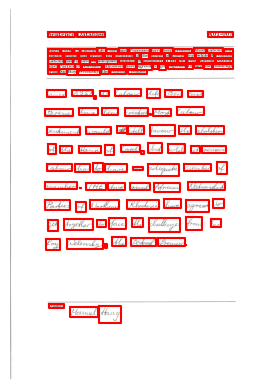

a01-007u.png


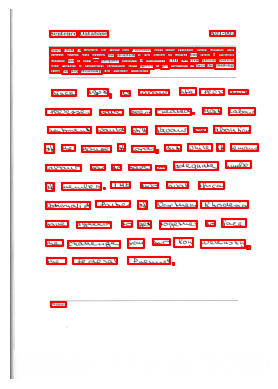

In [21]:
import numpy as np

def plot_img_with_polygons(key, data):
    filepath = "text_detection_train/images/" + key

    plt.axis('off')
    plt.imshow(plt.imread(filepath), cmap='gray')    

    for polygon_data in data[key]['polygons']:
        x = []
        y = []
        for point in polygon_data:
            x.append(point[0])
            y.append(point[1])
        x.append(polygon_data[0][0])
        y.append(polygon_data[0][1])
        plt.plot(x, y, color='red')
    plt.show()

i = 0
stop = 3
for key in train_json:
    i += 1
    print(key)
    plot_img_with_polygons(key, train_json)
    if i >= stop:
        break

# Training

In [34]:
# import os
# os.system('python doctr/references/detection/train_tensorflow.py --help')

Run the following command to train Doctr

```bash
python doctr/references/detection/train_tensorflow.py text_detection_train text_detection_val db_resnet50 --pretrained --freeze-backbone --name fine_tuning_final
```

`--rotation`

https://developer.apple.com/forums/thread/693678

```bash
pip uninstall tensorflow-metal
```

# Evaluating

In [22]:
from doctr.models import ocr_predictor

test_form_id = df.iloc[0].form_id
form_img_path = get_preprocessed_form_img_path_from_id(test_form_id)

def get_original_doctr_prediction(filepath, size=(1,1)):
    original_model = ocr_predictor(
        det_arch = 'db_resnet50',    
        reco_arch = 'crnn_vgg16_bn', 
        pretrained = True
    )
    doc = DocumentFile.from_images(filepath)
    det_res = original_model.det_predictor(doc)
    return scale_doctr_coords(det_res[0], size)

doctr_test_coords = get_original_doctr_prediction(form_img_path)


In [23]:
from doctr.models import ocr_predictor


form_img_path = df.iloc[0].form_img_path

In [24]:
from typing import List, Tuple
from shapely.geometry import box, Polygon, Point
import geopandas

def get_ground_truth_polygon_boundaries(ground_truth_polygons: List[box], tolerance= 50):
    ymin = None
    ymax = None

    for b in ground_truth_polygons:
        for point in list(b.exterior.coords):
            if ymin is None:
                ymin = point[1]
            if ymax is None:
                ymax = point[1]

            if point[1] < ymin:
                ymin = point[1]
            if ymax < point[1]:
                ymax = point[1]
    return (ymin - tolerance, ymax + tolerance)

def get_ground_truth_polygons_from_df(df: pd.DataFrame) -> List[box]:
    boxes = []
    for index, row in df.iterrows():
        # (minx, miny, maxx, maxy)
        boxes.append(box(row.x, row.y, row.x + row.w, row.h + row.y))
    return boxes

def get_iou(ground_truth_polygons, predicted_polygons):
    ground_truth_union = Point(0, 0)
    for polygon in ground_truth_polygons:
        ground_truth_union = ground_truth_union.union(polygon)
    # ground_truth_union = unary_union(ground_truth_polygons)

    prediction_union = Point(0, 0)
    for polygon in predicted_polygons:
        prediction_union = prediction_union.union(polygon)
    # prediction_union = unary_union(prediction_polygons)
    
    area_of_union = ground_truth_union.union(prediction_union)
    area_of_intersection = ground_truth_union.intersection(prediction_union)

    return (geopandas.GeoSeries(area_of_intersection).area / geopandas.GeoSeries(area_of_union).area)[0]

def get_in_bounds_doctr_polygons(doctr_boxes, boundaries):
    boxes = []
    for b in doctr_boxes:
        xmin = b[0]
        ymin = b[1]
        xmax = b[2]
        ymax = b[3]
        if ymin > boundaries[0] and ymin < boundaries[1]:
            boxes.append(box(
                xmin,
                ymin,
                xmax,
                ymax
                )
            )
    return boxes


In [25]:
straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
straight_model.det_predictor.model.load_weights(DET_CKPT)

base_model = ocr_predictor(
    det_arch = 'db_resnet50',    
    reco_arch = 'crnn_vgg16_bn', 
    pretrained = True
)

In [39]:
import os

def get_custom_doctr_prediction_boxes(custom_model, filepath, size=(1,1), boundaries = None)->List[box]: 
    doc = DocumentFile.from_images(filepath)
    det_res = custom_model.det_predictor(doc)
    boxes = []
    for b in det_res[0]:
        xmin = b[0] * size[1]
        ymin = b[1] * size[0]
        xmax = b[2] * size[1]
        ymax = b[3] * size[0]
        if boundaries is None or (ymin > boundaries[0] and ymin < boundaries[1]):
            boxes.append(box(
                xmin,
                ymin,
                xmax,
                ymax
            ))
    return boxes

def compute_iou_from_form_df(custom_model, form_df, with_plot=False, is_saving=False, base_model = None):
    assert(len(form_df) > 0)
    first_form_entry = form_df.iloc[0]
    form_img_path = first_form_entry.form_img_path
    form_img = plt.imread(form_img_path)
    form_size = form_img.shape
    ground_truth_polygons = get_ground_truth_polygons_from_df(form_df)
    boundaries = get_ground_truth_polygon_boundaries(ground_truth_polygons)
    predicted_polygons = get_custom_doctr_prediction_boxes(custom_model, form_img_path, (form_size[0], form_size[1]), boundaries)
    base_predicted_polygons = None
    base_iou = 0
    if not base_model is None:
        base_predicted_polygons = get_custom_doctr_prediction_boxes(base_model, form_img_path, (form_size[0], form_size[1]), boundaries)
        base_iou = get_iou(ground_truth_polygons, base_predicted_polygons)

    iou = get_iou(ground_truth_polygons, predicted_polygons)
    if with_plot:
        first_form_entry.form_id
        plt.figure(figsize=(20,10))
        plt.title("Form id {} / Writer id {}".format(first_form_entry.form_id, first_form_entry.writer_id))
        plt.imshow(form_img)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

        for box in predicted_polygons:
            box = box.exterior.xy
            xx = box[0].tolist()
            yy = box[1].tolist()
            plt.plot(xx, yy, color='red', label='Predicted')

        for box in ground_truth_polygons:
            box = box.exterior.xy
            xx = box[0].tolist()
            yy = box[1].tolist()
            plt.plot(xx, yy, color='green', label='Ground truth')

        if not base_predicted_polygons is None: 
            for box in base_predicted_polygons:
                box = box.exterior.xy
                xx = box[0].tolist()
                yy = box[1].tolist()
                plt.plot(xx, yy, color='purple', label='Base predicted', linestyle='dashed')
            plt.text(0.45 * form_size[1], 0.95 * form_size[0], "Base IoU: {}".format(round(base_iou, 2)), fontsize=14, bbox=props)

        plt.text(0.45 * form_size[1], 0.85 * form_size[0], "IoU: {}".format(round(iou, 2)), fontsize=14, bbox=props)
        if is_saving:
            iou_str = str(round(iou, 1)).replace('.', '_')
            base_dir = "form_iou/{}".format(iou_str)
            if not os.path.exists(base_dir):
                os.makedirs(base_dir)
            plt.savefig("{}/form_{}__{}.png".format(base_dir, first_form_entry.form_id, first_form_entry.writer_id))
        plt.show()
    return iou, base_iou

def run_iou():
    avg_iou = 0
    avg_base_iou = 0
    count = 0
    for form_id in list(set(df['form_id'])):
        form_df = df[df['form_id'] == form_id]
        all_form_writer_ids = list(set(form_df['writer_id']))
        for writer_id in all_form_writer_ids:
            tmp_df = form_df[form_df['writer_id'] == writer_id]
            iou, base_iou = compute_iou_from_form_df(straight_model, tmp_df, False, False, base_model=base_model)
            count = count + 1
            avg_iou = avg_iou + iou
            avg_base_iou = avg_base_iou + base_iou

    avg_iou = avg_iou / count
    avg_base_iou = avg_base_iou / count

    print("The average iou is {}".format(avg_iou))
    print("The average base iou is {}".format(avg_base_iou))

# run_iou()

The average iou is 0.44917920478222806
The average base iou is 0.6682423415428593


The average iou is 0.44917920478222806

The average base iou is 0.6682423415428593

# Test with subform img

In [26]:
df = pd.read_pickle('../../pickle/df.pickle')
df['form_img_path'] = '../' + df['form_img_path_y']
df = df.drop(columns=['form_img_path_y'])

bad_df = df[df['total_words'] != df['correct_words']]
df = df[df['total_words'] == df['correct_words']]
df.head()

,index,word_id,gray_level,x,y,w,h,tag,transcription,word_img_path,...,form_id,writer_id,text_id,number_of_sentences,word_seg,total_lines,correct_lines,total_words,correct_words,form_img_path
36,52,a01-000x-00-00,182,375,767,35,67,AT,A,../data/words/a01/a01-000x/a01-000x-00-00.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
37,53,a01-000x-00-01,182,506,763,143,66,NN,MOVE,../data/words/a01/a01-000x/a01-000x-00-01.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
38,54,a01-000x-00-02,182,730,760,44,70,TO,to,../data/words/a01/a01-000x/a01-000x-00-02.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
39,55,a01-000x-00-03,182,832,764,89,114,VB,stop,../data/words/a01/a01-000x/a01-000x-00-03.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png
40,56,a01-000x-00-04,182,1001,760,84,71,NPT,Mr.,../data/words/a01/a01-000x/a01-000x-00-04.png,...,a01-000x,001,a01,2,all,6,6,52,52,../../data/formsA-D/a01-000x.png


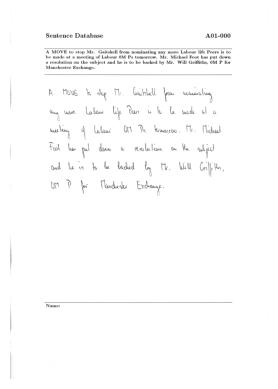

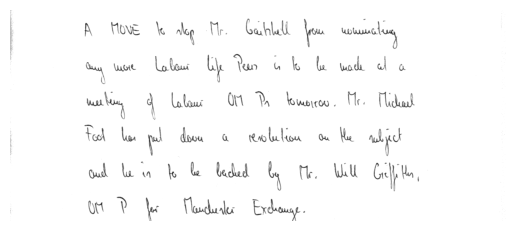

In [31]:
test_form_img_path = df.iloc[5].form_img_path
form_id =  df.iloc[5].form_id

form_df = df[(df['form_id'] == form_id)]
margin = 50
boundaries = form_df.y.min() - margin, form_df.y.max() + margin  
# y = y - boundaries[0]  

img_array = preprocess(test_form_img_path, img_size=FORM_IMG_SIZE, with_rotation=False).numpy()
plt.axis('off')
plt.imshow(img_array, cmap='gray');
plt.show()

cut_img_array = img_array[boundaries[0]:boundaries[1], :]
plt.axis('off')
plt.imshow(cut_img_array, cmap='gray');
plt.show()

In [41]:
import hashlib
import os

IMG_DIM_ATTR_LABEL = 'img_dimensions'
IMG_HASH_ATTR_LABEL = 'img_hash'
POLYGON_ATTR_LABEL = 'polygons'
IS_TRAIN_ATTR_LABEL = 'is_train'


def get_img_hash(img_arr):
    return hashlib.sha256(img_arr).hexdigest()

def get_cut_preprocessed_form_img_path_from_id(form_id):
    return PREPROCESSED_FORM_IMG_PATH + form_id + '.png'

def split_in_train_val_img_dicts(df, save=SHOULD_REBUILD):
    if not save:
        with open("cut_text_detection_train/labels.json") as f:
            train_json = json.load(f)
            
        print(len(train_json), "images will be used for training")

        with open("cut_text_detection_val/labels.json") as f:
            val_json = json.load(f)
            
        print(len(val_json), "images will be used for validation")
        return train_json, val_json
    
    train_img_dict = {}
    val_img_dict = {}

    i = 0
    nb_forms = len(list(set(df.form_id)))
    form_ids = set()
    form_img_infos = {}



    for index, row in tqdm(df.iterrows(), total=len(df)):
        i += 1
        # if i > 10: 
        #     break
        x = row.x
        y = row.y
        width = row.w
        height = row.h
        form_id = row.form_id
        form_ids.add(form_id)
        form_img_path = get_preprocessed_form_img_path_from_id(row.form_id)

        is_train = (len(form_ids) < int(nb_forms * 0.8))     

        
        form_df = df[(df['form_id'] == form_id)]
        margin = 50
        boundaries = form_df.y.min() - margin, form_df.y.max() + margin  
        y = float(y - boundaries[0])      

        box_coordinates = [
            [x, y],
            [x + width, y],
            [x + width, y + height],
            [x, y + height],
        ]

        form_img_filename = row.form_id + '.png'
        form_img_filename = form_img_filename.split('/')[-1]

        # Save cut image
        if is_train:
            future_img_path = 'cut_text_detection_train/images/' + form_img_filename
        else:
            future_img_path = 'cut_text_detection_val/images/' + form_img_filename

        if not os.path.exists(future_img_path):
                # Save cut img 
                form_img_arr = form_img_arr[boundaries[0]:boundaries[1], :, :]
                plt.imsave(future_img_path, form_img_arr, cmap='gray')
        # END Save cut image

        if form_img_path in form_img_infos:
            form_img_hash = form_img_infos[form_img_path]['hash']
            img_shape = form_img_infos[form_img_path]['shape']
        else:
            form_img_arr = plt.imread(future_img_path)
            form_img_hash = get_img_hash(form_img_arr)
            img_shape = form_img_arr.shape

            form_img_infos[form_img_path] = {
                'hash': form_img_hash,
                'shape': img_shape,
            }

        if is_train:
            if not form_img_filename in train_img_dict:
                train_img_dict[form_img_filename] = {
                    IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                    IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                    POLYGON_ATTR_LABEL: [],
                }
            train_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)
        else: 
            if not form_img_filename in val_img_dict:
                val_img_dict[form_img_filename] = {
                    IMG_DIM_ATTR_LABEL: form_img_arr.shape,
                    IMG_HASH_ATTR_LABEL: get_img_hash(form_img_arr),
                    POLYGON_ATTR_LABEL: [],
                }
            val_img_dict[form_img_filename][POLYGON_ATTR_LABEL].append(box_coordinates)

    with open("cut_text_detection_train/labels.json", "w") as outfile:
        json.dump(train_img_dict, outfile, indent=4, sort_keys=False)
    with open("cut_text_detection_val/labels.json", "w") as outfile:
        json.dump(val_img_dict, outfile, indent=4, sort_keys=False)

    return train_img_dict, val_img_dict

train_json, val_json = split_in_train_val_img_dicts(df, save=True)

100%|██████████| 41981/41981 [02:20<00:00, 298.61it/s]


a01-000x.png


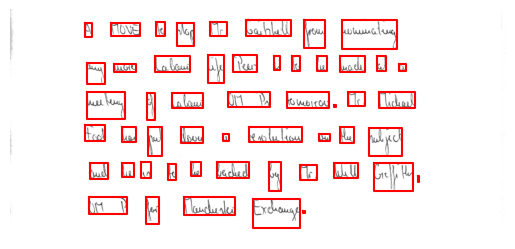

a01-007.png


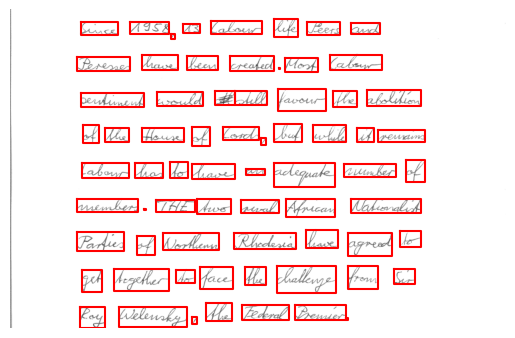

a01-007u.png


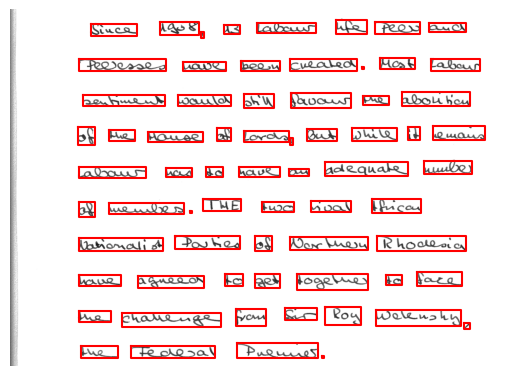

In [43]:
import numpy as np

def plot_img_with_polygons(key, data):
    filepath = "cut_text_detection_train/images/" + key

    plt.axis('off')

    plt.imshow(plt.imread(filepath), cmap='gray')    

    for polygon_data in data[key]['polygons']:
        x = []
        y = []
        for point in polygon_data:
            x.append(point[0])
            y.append(point[1])
        x.append(polygon_data[0][0])
        y.append(polygon_data[0][1])
        plt.plot(x, y, color='red')
    plt.show()

i = 0
stop = 3
for key in train_json:
    i += 1
    print(key)
    plot_img_with_polygons(key, train_json)
    if i >= stop:
        break